In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
from PIL import Image

In [33]:
def stretch(img):
    '''
    图像拉伸函数
    '''
    maxi=float(img.max())
    mini=float(img.min())

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i,j]=(255/(maxi-mini)*img[i,j]-(255*mini)/(maxi-mini))

    return img

In [34]:
def find_rectangle(contour):
    '''
    寻找矩形轮廓
    '''
    y, x = [], []

    for p in contour:
        y.append(p[0][0])
        x.append(p[0][1])

    return [min(y), min(x), max(y), max(x)]


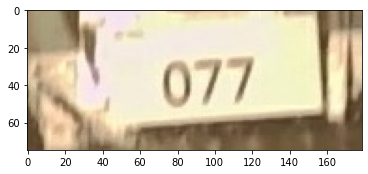

In [35]:
rawimg0 = cv2.imread("cut.jpg",1) #原始照片

# 對照片進行定位後裁切
cropped = rawimg0[20:60,60:140]
#cropped = cv2.fastNlMeansDenoisingColored(rawimg0,None,10,10,7,21)

# 查看裁切後的照片
plt.imshow(rawimg0)

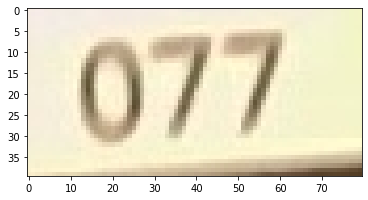

In [36]:
plt.imshow(cropped)

In [37]:
# 圖片灰階
grayscaleimg = cv2.cvtColor(cropped,cv2.COLOR_BGR2GRAY)
#plt.imshow(grayscaleimg,cmap='gray')

#灰度拉伸
stretchedimg=stretch(grayscaleimg)

25


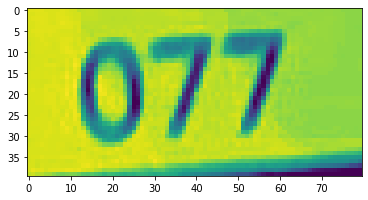

In [51]:
#进行开运算，用来去除噪声
r=25
h=w=r*2+1
kernel=np.zeros((h,w),np.uint8)
cv2.circle(kernel,(r,r),r,1,-1)
#开运算
openingimg=cv2.morphologyEx(stretchedimg,cv2.MORPH_OPEN,kernel)
#获取差分图，两幅图像做差  cv2.absdiff('图像1','图像2')
strtimg=cv2.absdiff(stretchedimg,openingimg)
print(r)
plt.imshow(strtimg)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]]


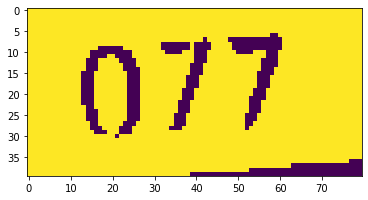

In [52]:
# 圖片二值化
maxi = float(strtimg.max())
mini = float(strtimg.min())
x = maxi - ((maxi - mini) / 2)
ret, binary = cv2.threshold(strtimg,x, 255, cv2.THRESH_BINARY) # 110這個數字可改
#plt.imshow(binary,cmap='Greys',interpolation='None')
rawimg = binary - binary[0,1] #有這欄 圖的最低就會變成0 圖會變成黑底白字
plt.imshow(binary)
print(binary)

In [53]:
#侵蝕雜訊
kernel=np.ones((5,5),np.uint8)
binary = cv2.erode(binary,kernel,iterations=1)

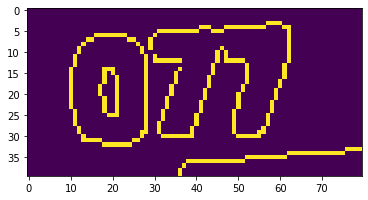

In [54]:
# canny边缘检测
canny = cv2.Canny(binary, binary.shape[0], binary.shape[1])
plt.imshow(canny)

In [55]:
# 进行闭运算
kernel = np.ones((8, 8), np.uint8)
closingimg = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel)
# 进行开运算
kernel=np.ones((10,10),np.uint8)
openingimg = cv2.morphologyEx(closingimg, cv2.MORPH_OPEN, kernel)

# 再次进行开运算
kernel = np.ones((11, 5), np.uint8)
openingimg = cv2.morphologyEx(openingimg, cv2.MORPH_OPEN, kernel)

# 消除小区域，定位车牌位置
rect = locate_license(openingimg, rawimg0)
print(rect)
i__=rawimg0[18:42,164:178]
plt.imshow(i__)

ValueError: not enough values to unpack (expected 3, got 2)

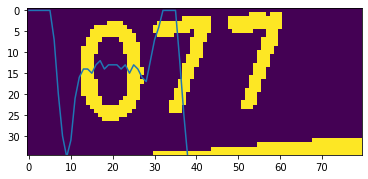

In [28]:
# counting non-zero value by row , axis y
row_nz = []
for row in rawimg.tolist():
    row_nz.append(len(row) - row.count(0))
plt.plot(row_nz)


idx=np.array(row_nz)>(max(row_nz)/4) #截出上下的範圍
np.where(idx==1)[0][0],np.where(idx==1)[0][-1]
up_y=np.where(idx==1)[0][-1]+2 #上界
down_y=np.where(idx==1)[0][0]-2 #下界
rawimg1=rawimg[down_y:up_y,]
plt.imshow(rawimg1)

[13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]
27
[13, 28]
[29, 79]


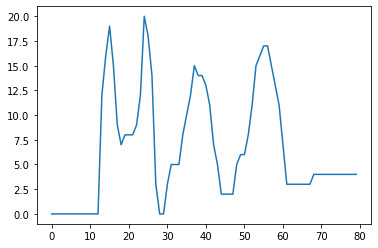

In [29]:
# counting non-zero value by column, x axis
col_nz = []
for col in rawimg1.T.tolist():
    col_nz.append(len(col) - col.count(0))
plt.plot(col_nz)

idy=np.not_equal(col_nz,0)
print(np.where(idy==1)[0])
record_y=[] #如果有八個數字，裡面應該要有九個格子(一開始找出七個，前後插入變九個)
record_x=[]
for i in range(0,(len(np.where(idy==1)[0])-1)):
    
    # 如果下一個數是0就略過，直到找到下一個數不是0的位置
    con=np.where(idy==1)[0][i+1]-np.where(idy==1)[0][i]
    if(con==1):
        pass
    else:
        print(np.where(idy==1)[0][i])
        record_x.append(np.where(idy==1)[0][i+1]-2)
        record_y.append(np.where(idy==1)[0][i]+2)

# 插入第一個非0位置跟最後一個非0的位置
record_x.insert(0,np.where(idy==1)[0][0])
record_y.append(np.where(idy==1)[0][-1])
print(record_x)
print(record_y)

In [30]:
import tensorflow as tf
from tensorflow.keras.models import load_model
model = load_model("keras_model.h5")

(28, 28, 3)
(28, 28, 3)
1
(28, 28, 3)
(28, 28, 3)
8
18


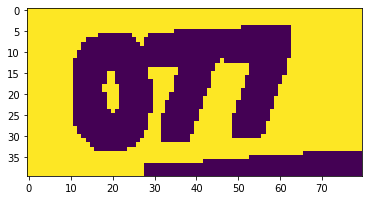

In [31]:
mypic=1
ans=""
for i in range(0,len(record_y)):
    a=binary[down_y:up_y,record_x[i]:record_y[i]]
    a=cv2.resize(a, (28, 28), interpolation=cv2.INTER_CUBIC)
    
    img_name='%s-%s.png'%(mypic,i+1)
    cv2.imwrite(img_name,a)
    
    image = np.zeros((28,28,3))
    print(image.shape)
    image[:,:,0]=a
    image[:,:,1]=a
    image[:,:,2]=a
    
    x=np.array(image).astype('float32')/255.
    print(x.shape)
    pre=model.predict(x.reshape(1,28,28,3))
    y_label = np.argmax(pre)
    print(y_label)
    ans+=str(y_label)
    #plt.imshow(a)
    
plt.imshow(binary)
print(ans)